# Data Preprocessing Template Lite
1. Import lib
1. Import data
1. EDA - Exploratory Data Analysis
1. Separate target and features
1. Split train set and test set (80/20)
1. Cleaning
    1. Replace missing val
    1. Standardize numerical features + One hot encode categorical variables
    1. Encode labels of y
1. Apply pre processing to test set
1. Predict and evaluate


## Step 1 - Import libraries

In [60]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

## Step 2 - Import dataset

In [61]:
df = pd.read_csv("99-assets/ML/Data.csv")
df.head()

,Country,Age,Salary,Purchased
0,France,44.0,72000.0,No
1,Spain,27.0,48000.0,Yes
2,Germany,30.0,54000.0,No
3,Spain,38.0,61000.0,No
4,Germany,40.0,NaN,Yes


## Step 3 - EDA - Exploratory Data Analysis

### Voir par exemple que ici :
* Y a des valeurs manquantes pour toutes les colonnes (count pas identique partout)
* 3 catégories uniques de pays
* target (purchased) de type Yes/No

(10, 4)

       Country        Age        Salary Purchased
count       10   9.000000      9.000000        10
unique       3        NaN           NaN         2
top     France        NaN           NaN        No
freq         4        NaN           NaN         5
mean       NaN  38.777778  63777.777778       NaN
std        NaN   7.693793  12265.579662       NaN
min        NaN  27.000000  48000.000000       NaN
25%        NaN  35.000000  54000.000000       NaN
50%        NaN  38.000000  61000.000000       NaN
75%        NaN  44.000000  72000.000000       NaN
max        NaN  50.000000  83000.000000       NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    10 non-null     object 
 1   Age        9 non-null      float64
 2   Salary     9 non-null      float64
 3   Purchased  10 non-null     object 
dtypes: float64(2), object(2)
memory usage: 452.0

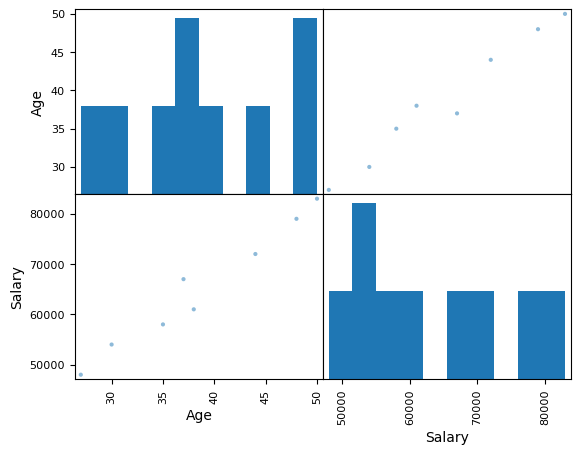

In [62]:
print(df.shape)                       # (#rows, #columns)

print()
print(df.describe(include="all")) # include non numerical info

print()
df.info()

print()
df["Country"].value_counts()

attributes = ["Age", "Salary"]
_ = scatter_matrix(df[attributes])


# Vérifier que le count est identique pour toutes les colonnes
# Attention on peut avoir le même nb de valeurs qui manquent partout
# Faut correler avec df.shape
# Vérifier les unités
# Les gammes de valeurs des données

# df.drop(["Country"], axis=1, inplace = True)
# df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])

# vérifier si il y a des lignes dupliquées
# duplicates = df[df.duplicated()]
# print("Duplicate Rows:", duplicates)
# df = df.drop_duplicates()

# df.value_counts()
# df["Country"].value_counts()/len(df)

# print(df[df['Embarked'].isna()])                                      # print lines with NaN
# df.isna().mean() * 100
# df.isna().sum() / len(df) * 100                                       # print nb of Nan as %
# isnull() = isna() mais isna() est plus récente

# Créer des combinaisons de variables
# df["debile"] = df["Salary"]/df["Age"]

# df.drop("debile", axis=1)

# corr_matrix = df.corr(numeric_only=True)
# print(corr_matrix)
# print()
# print(corr_matrix["Survived"].sort_values(ascending=False))

# chercher les outliers
# from scipy.stats import zscore
# z_scores = zscore(df)
# z_scores = np.abs(z_scores)
# outliers = (z_scores > 3).all(axis=1)

# chercher les outliers
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1 # interquartile range
# outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

#########################################################################
# Graphes
# _ = df.hist(bins=50)                                                  # affiche une matrice avec tous les histogrammes 
# df["Country"].hist()

# from pandas.plotting import scatter_matrix                            # affiche une matrice avec le graphes des correlation entre features 
# attributes = ["nom1", "nom2", "nom3"]
# scatter_matrix(housing[attribute], figsize=(10, 10))

# sns.catplot(data = df, x="Sex", y="Survived", kind="bar")
# housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
              #  s=housing["population"]/75, label="population",
              #  c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,10))
# _ = plt.legend()

#sns.histplot(df['Positive_Axillary_Nodes'], bins=15, kde=True, color='lightgreen') # kernel density estimate (kde=True) 
                                                                                    # smoothed probability density function

# sns.heatmap(df.corr(numeric_only=True));   

# attributes = ["Age", "Salary"]
# _ = scatter_matrix(df[attributes])

# Camembert
#marital_counts = df['Marital_Status'].value_counts()
#plt.figure(figsize=(10, 6))
#plt.pie(marital_counts, labels=marital_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Blues'))

# Courbe cumulée
# plt.figure(figsize=(10, 6))
# sns.ecdfplot(df['Age_Group'], color='purple')

# Generate heatmap
# corr_matrix = df.corr()
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# Plotting violin plots for selected features
# for feature in selected_features:
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(x='Survival_Status', y=feature, data=df, hue='Survival_Status', palette='Blues', inner='quartile', legend=False)
#     plt.title(f'Violin Plot for {feature} by Survival Status')
#     plt.xlabel('Survival Status')
#     plt.ylabel(feature)
#     plt.show()

# sns.pairplot(df, hue='Survival_Status')

# plt.figure(figsize=(7, 6))
# sns.scatterplot(x='Tumor_Size', y='Positive_Axillary_Nodes', data=df, hue='Survival_Status', palette='pastel')

# sns.jointplot(x='Age', y='Positive_Axillary_Nodes', data=df,color='lightblue')
# plt.show()

# sns.jointplot(x = 'patient_age',  y = 'operation_year' , data = df,  kind = 'kde', fill = True)
# plt.show()


## Step 4 - Separate target and features

In [63]:
features_list = ["Country", "Age", "Salary"]
X = df.loc[:, features_list]
y = df.loc[:, "Purchased"]
# print(X.head())
# print(y.head())

## Step 5 - Split Train & Test sets

In [64]:
# Usually : 80% training and 20% testing  
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0,       # donne une valeur pour être sûr d'avoir toujours le même comportement random
                                                    stratify=y)           # Allows you to stratify our sample. 
                                                                          # We will have the same proportion of categories in test and train set

## Step 6 - Cleaning

1. Remplace missing values - SimpleImputer avec strategy='mean' pour valeurs numériques ou strategy='mode' si il manque des données catégorielles
1. Standardize numerical features + One hot encode categorical variables
1. If y is discrete => Encode labels of y

### 6.1 - Replace missing values

In [65]:
# Missing values - SimpleImputer
# Si il avait manqué un nom de pays, on aurait pu utiliser une strategie "mode" pour remplacer par le pays le plus fréquent
print(X_train)
imputer = SimpleImputer(strategy="mean")  # Instanciate class of SimpleImputer with strategy of mean
#X_train = X_train.copy()                 # ! Copy dataset to avoid caveats of assign a copy of a slice of a DataFrame
                                          # Semble plus nécessaire en 2023
                                          # More info here https://towardsdatascience.com/explaining-the-settingwithcopywarning-in-pandas-ebc19d799d25

X_train.iloc[:,[1,2]] = imputer.fit_transform(X_train.iloc[:,[1,2]]) # Fit and transform columns where there are missing values
print() 
print(X_train) 

   Country   Age   Salary
0   France  44.0  72000.0
4  Germany  40.0      NaN
6    Spain   NaN  52000.0
9   France  37.0  67000.0
3    Spain  38.0  61000.0
1    Spain  27.0  48000.0
2  Germany  30.0  54000.0
5   France  35.0  58000.0

   Country        Age        Salary
0   France  44.000000  72000.000000
4  Germany  40.000000  58857.142857
6    Spain  35.857143  52000.000000
9   France  37.000000  67000.000000
3    Spain  38.000000  61000.000000
1    Spain  27.000000  48000.000000
2  Germany  30.000000  54000.000000
5   France  35.000000  58000.000000


### 6.2 - Standardize numerical features + One hot encode categorical variables

In [66]:
# Standardizing numeric features and encoding categorical features
# OneHotEncoder = codage disjonctif complet en FR

numeric_features = [1, 2]                             # On crée une liste avec les indices des colonnes qui contiennent des valeurs numériques
                                                      # Age et Salaires sont dans les colonnes 1 et 2
numeric_transformer = StandardScaler()                # On précise le type de transformer qu'on veut utiliser pour les val numériques

categorical_features = [0]                            # On crée une liste avec les indices des colonnes qui contiennent des valeurs catégorielles
                                                      # Les pays sont dans la colonne d'indice 0 (la première)
categorical_transformer = OneHotEncoder(drop='first') # Pour virer l'Angleterre comme dans l'exemple ci-dessus on aurait mis drop="last" mais ça n'existe pas
                                                      # Il faut garder le drop first car sinon on a 2 colonnes 
                                                      # qui sont 100% corrélées est c'est pas bon pour le modèle

featureencoder = ColumnTransformer(                   # ColumnTransformer provient du module compose
  transformers=[                                      # On passe une liste de transformers à qui ont donne un nom (cat, num...)
    ('cat', categorical_transformer, categorical_features),   
    ('num', numeric_transformer, numeric_features)
  ]
)

# La variable featureencoder est un object de type ColumnTransformer
# Elle contient la "recette" pour transformer chacune des colonnes
# Sur les colonnes 1 et 2 qui sont de type numérique appliquer StandarScaler
# Sur la colonne 0 qui est de type catégorielle, appliquer OneHotEncoder
# ... 
# L'énorme avantage de procéder comme ça c'est que 
#     si on veut tester un ou ajouter des transformers sur des colonnes on peut le faire en modifiant le code à un seul endroit
#     on est sûr d'appliquer la même "recette" plus tard à nos données de test (X_test)

X_train = featureencoder.fit_transform(X_train)
print(X_train[:5])  # print first 5 rows (not using iloc since now X_train became a numpy array)
                    # ! X_train became a numpy array
                    # bob = pd.DataFrame(X_train, columns=["Code 1", "Code 2", "age", "salary"])
                    # print(bob)


# On a 4 colonnes à l'affichage car il y a 2 pays, age et salary
# France    => 0 et 0
# Allemagne => 1 et 0
# Spain     => 0 et 1


[[ 0.00000000e+00  0.00000000e+00  1.61706195e+00  1.78674463e+00]
 [ 1.00000000e+00  0.00000000e+00  8.22715727e-01  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.41104234e-15 -9.32214592e-01]
 [ 0.00000000e+00  0.00000000e+00  2.26956063e-01  1.10700483e+00]
 [ 0.00000000e+00  1.00000000e+00  4.25542617e-01  2.91317060e-01]]
   Code 1  Code 2           age    salary
0     0.0     0.0  1.617062e+00  1.786745
1     1.0     0.0  8.227157e-01  0.000000
2     0.0     1.0 -1.411042e-15 -0.932215
3     0.0     0.0  2.269561e-01  1.107005
4     0.0     1.0  4.255426e-01  0.291317
5     0.0     1.0 -1.758909e+00 -1.476006
6     1.0     0.0 -1.163150e+00 -0.660319
7     0.0     0.0 -1.702170e-01 -0.116527


### 6.3 - Encode labels of y

In [8]:
# Encoding labels
# Replace "yes" / "no" by `0` and `1` which can be interpreted by a computer. 

print(y_train)
labelencoder = LabelEncoder()                       # LabelEncoder provient de sklearn.preprocessing
                                                    # Va transformer les Yes, No en 0, 1
                                                    # Si on avait eu Riri, Fifi, Loulou en lables différents
                                                    # il aurait codé en 0, 1 et 2
y_train = labelencoder.fit_transform(y_train)
print(y_train[:5])                                  # print first 5 rows (not using iloc since now y_train became a numpy array)
                                                    # ! y_train became a numpy array

0     No
4    Yes
6     No
9    Yes
3     No
1    Yes
2     No
5    Yes
Name: Purchased, dtype: object
[0 1 0 1 0]


## Step X - Training

## Step 7 - Apply preprocessing to test set

In [9]:
# 5.1 - Missing values
# print(X_test)
# X_test = X_test.copy()                                          # !Z
                                                                  # Semble plus nécessaire en 2023
X_test.iloc[:,[1,2]] = imputer.transform(X_test.iloc[:,[1,2]])    # On réutilise l'objet imputer
# print(X_test) 

# 5.2 - Encoding categorical features and standardizing numeric features
X_test = featureencoder.transform(X_test)       # On réutilise la "recette" contenue dans l'objet featureencoder
                                                # On est sûr et certains de traiter les données de test de la même façon que les données de training  
# print(X_test)

# 5.3 - Encoding labels
# print(y_test)
y_test = labelencoder.transform(y_test)         # On réutilise l'objet labelencoder
# print(y_test)

## Step 8 - Predict and evaluate